# PyMEOS Demo for ACM Demo

In [2]:
from functools import partial

import contextily as cx
import pandas as pd
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter, TemporalSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm
import plotly.express as px

tqdm.pandas()
pymeos_initialize()

In [32]:
data = 'selection'
# data = 'full'

## Preprocessing

In [4]:
raw = pd.read_csv(f'{data}/singapore.csv', header=0,
                  names=['ID', 'Trajectory ID', 'Driving Mode', 'OS Name', 'Timestamp', 'Latitude', 'Longitude',
                         'Speed', 'Bearing', 'Accuracy'],
                  usecols=['Trajectory ID', 'Timestamp', 'Latitude', 'Longitude', 'Speed', 'Bearing', 'Accuracy'])
raw.head()

Trajectory ID   Timestamp  Latitude   Longitude      Speed  Bearing   
0           8372  1554816841  1.272560  103.802258   7.926254      312  \
1          78872  1555327308  1.337353  103.887384  16.915829      335   
2           8372  1554817378  1.330298  103.815009  17.113640       33   
3           3671  1555383449  1.298167  103.781857  18.855305      118   
4          78872  1555326377  1.353826  103.968034   9.147378      237   

   Accuracy  
0      18.0  
1      15.0  
2       8.0  
3       3.9  
4      10.0

We preprocess the row data so that:
- Rows that have null values are deleted.
- Timestamps are converted from millis since epoch to `datetime` objects.
- A new column with Shapely Points is generated.
- Points are transformed from EPSG:4326 to EPSG:3414

In [5]:
raw = raw.dropna()
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'], origin='unix', unit='s')
raw['Location'] = shp.points(raw['Longitude'], raw['Latitude'])
raw.head()

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0           8372 2019-04-09 13:34:01  1.272560  103.802258   7.926254  \
1          78872 2019-04-15 11:21:48  1.337353  103.887384  16.915829   
2           8372 2019-04-09 13:42:58  1.330298  103.815009  17.113640   
3           3671 2019-04-16 02:57:29  1.298167  103.781857  18.855305   
4          78872 2019-04-15 11:06:17  1.353826  103.968034   9.147378   

   Bearing  Accuracy                                       Location  
0      312      18.0  POINT (103.80225795977768 1.2725603991465335)  
1      335      15.0  POINT (103.88738391756964 1.3373532194158333)  
2       33       8.0   POINT (103.8150094268266 1.3302980845939048)  
3      118       3.9                  POINT (103.7818567 1.2981667)  
4      237      10.0     POINT (103.96803368289672 1.3538260973655)

In [6]:
wgs84 = pyproj.CRS('EPSG:4326')
svy21 = pyproj.CRS('EPSG:3414')

project = partial(transform, pyproj.Transformer.from_crs(wgs84, svy21, always_xy=True).transform)

raw['Location'] = raw['Location'].progress_map(project)
raw.head()

  0%|          | 0/324540 [00:00<?, ?it/s]

Trajectory ID           Timestamp  Latitude   Longitude      Speed   
0           8372 2019-04-09 13:34:01  1.272560  103.802258   7.926254  \
1          78872 2019-04-15 11:21:48  1.337353  103.887384  16.915829   
2           8372 2019-04-09 13:42:58  1.330298  103.815009  17.113640   
3           3671 2019-04-16 02:57:29  1.298167  103.781857  18.855305   
4          78872 2019-04-15 11:06:17  1.353826  103.968034   9.147378   

   Bearing  Accuracy                                       Location  
0      312      18.0  POINT (24543.194560346834 28338.805006464638)  
1      335      15.0   POINT (34016.89841692408 35503.306897206625)  
2       33       8.0   POINT (25962.38012885203 34723.127579826876)  
3      118       3.9     POINT (22272.7495547345 31170.25496218118)  
4      237      10.0     POINT (42992.2724982164 37325.14364276941)

## PyMEOS objects generation
Now, we use the original dataset to build the PyMEOS temporal objects.

In [7]:
trajectories = raw[['Trajectory ID', 'Timestamp']].copy()

We start by generating an instant object (`TFloatInst` and `TGeomPointInst`) from the original data

In [8]:
trajectories['Speed'] = raw.progress_apply(lambda row: TFloatInst(value=row['Speed'], timestamp=row['Timestamp']),
                                           axis=1)
trajectories['Bearing'] = raw.progress_apply(lambda row: TFloatInst(value=row['Bearing'], timestamp=row['Timestamp']),
                                             axis=1)
trajectories['Location'] = raw.progress_apply(
    lambda row: TGeomPointInst(point=row['Location'], timestamp=row['Timestamp']), axis=1)
trajectories.head()

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

Trajectory ID           Timestamp   
0           8372 2019-04-09 13:34:01  \
1          78872 2019-04-15 11:21:48   
2           8372 2019-04-09 13:42:58   
3           3671 2019-04-16 02:57:29   
4          78872 2019-04-15 11:06:17   

                                       Speed                     Bearing   
0   7.926253795623779@2019-04-09 13:34:01+02  312@2019-04-09 13:34:01+02  \
1  16.915828704833984@2019-04-15 11:21:48+02  335@2019-04-15 11:21:48+02   
2   17.11363983154297@2019-04-09 13:42:58+02   33@2019-04-09 13:42:58+02   
3           18.855305@2019-04-16 02:57:29+02  118@2019-04-16 02:57:29+02   
4   9.147377967834473@2019-04-15 11:06:17+02  237@2019-04-15 11:06:17+02   

                                            Location  
0  POINT(24543.194560346834 28338.805006464638)@2...  
1  POINT(34016.89841692408 35503.306897206625)@20...  
2  POINT(25962.38012885203 34723.127579826876)@20...  
3  POINT(22272.7495547345 31170.25496218118)@2019...  
4  POINT(42992.2724982164 37325.14364276941)@2019...

In [9]:
t = trajectories[['Trajectory ID', 'Timestamp']].copy()
t['Speed'] = trajectories['Speed'].progress_map(lambda x: x.as_hexwkb())
t['Bearing'] = trajectories['Bearing'].progress_map(lambda x: x.as_hexwkb())
t['Location'] = trajectories['Location'].progress_map(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/singapore_instants.csv', index=False)

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

  0%|          | 0/324540 [00:00<?, ?it/s]

In [10]:
trajectories = pd.read_csv(f'{data}/singapore_instants.csv', parse_dates=['Timestamp'], converters={
    'Speed': TFloatInst.from_hexwkb,
    'Bearing': TFloatInst.from_hexwkb,
    'Location': partial(TGeomPointInst.from_hexwkb, srid=3414)
})
trajectories.head()

Trajectory ID           Timestamp   
0           8372 2019-04-09 13:34:01  \
1          78872 2019-04-15 11:21:48   
2           8372 2019-04-09 13:42:58   
3           3671 2019-04-16 02:57:29   
4          78872 2019-04-15 11:06:17   

                                       Speed                     Bearing   
0   7.926253795623779@2019-04-09 13:34:01+02  312@2019-04-09 13:34:01+02  \
1  16.915828704833984@2019-04-15 11:21:48+02  335@2019-04-15 11:21:48+02   
2   17.11363983154297@2019-04-09 13:42:58+02   33@2019-04-09 13:42:58+02   
3           18.855305@2019-04-16 02:57:29+02  118@2019-04-16 02:57:29+02   
4   9.147377967834473@2019-04-15 11:06:17+02  237@2019-04-15 11:06:17+02   

                                            Location  
0  POINT(24543.194560346834 28338.805006464638)@2...  
1  POINT(34016.89841692408 35503.306897206625)@20...  
2  POINT(25962.38012885203 34723.127579826876)@20...  
3  POINT(22272.7495547345 31170.25496218118)@2019...  
4  POINT(42992.2724982164 37325.14364276941)@2019...

Now, we sort the rows by time, and aggregate them by Trajectory ID, aggregating the columns in lists

In [11]:
trajectories = trajectories.sort_values(by='Timestamp').groupby('Trajectory ID').agg(list)
trajectories.head()

Timestamp   
Trajectory ID                                                      
10             [2019-04-09 11:25:50, 2019-04-09 11:25:54, 201...  \
23             [2019-04-21 02:42:49, 2019-04-21 02:42:51, 201...   
24             [2019-04-12 13:11:46, 2019-04-12 13:11:47, 201...   
66             [2019-04-15 04:24:31, 2019-04-15 04:24:42, 201...   
83             [2019-04-21 14:21:17, 2019-04-21 14:21:23, 201...   

                                                           Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                        Location  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

Finally, instants are merged into PyMEOS Sequences

In [12]:
trajectories['Speed'] = trajectories['Speed'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Bearing'] = trajectories['Bearing'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Trajectory'] = trajectories['Location'].progress_apply(
    lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(3414))
trajectories = trajectories.drop(['Location', 'Timestamp'], axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [13]:
t = trajectories[['Speed', 'Bearing', 'Trajectory']].copy()
t['Speed'] = t['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].map(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].map(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/singapore_trajectories.csv')

## Extracting interesting trips

In [14]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

We now plot the trajectories in a map to take an overall look at them.

In [15]:
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In this demo we will work cars that go (or pass by) the Singapore Airport and Gardens by the Bay, so we'll start creating a bounding box for each area.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the cars.

In [16]:
bay = shp.set_srid(shp.Point(32232.5740, 30189.7942), 3414)
airport = shp.set_srid(shp.Point(44452.1091, 35088.7227), 3414)

bay_bb = STBox.from_geometry_time(bay, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(1000)
airport_bb = STBox.from_geometry_time(airport, Period(lower='2019-04-08', upper='2019-04-22', upper_inc=True)).expand(
    1000)

joined_bb = (bay_bb + airport_bb).expand(100)

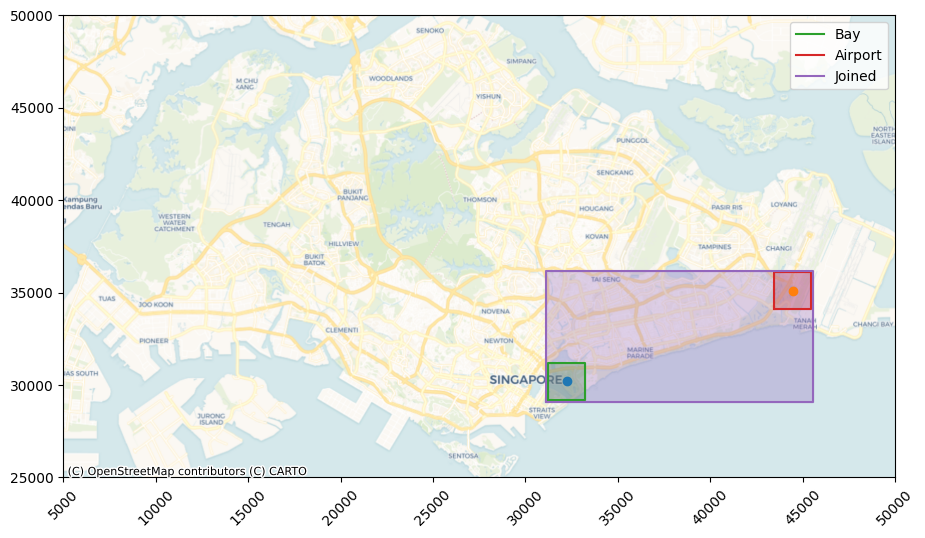

In [17]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(25000, 50000)
ax.set_xlim(5000, 50000)
_ = ax.plot(bay.x, bay.y, marker="o")
_ = ax.plot(airport.x, airport.y, marker="o")
_ = bay_bb.plot_xy(axes=ax, label='Bay')
_ = airport_bb.plot_xy(axes=ax, label='Airport')
_ = joined_bb.plot_xy(axes=ax, label='Joined')
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)
_ = plt.legend()

In [18]:
intersect_index = trajectories['Trajectory'].progress_map(lambda trip: trip.ever_intersects(joined_bb))
possible_trips = trajectories[intersect_index]
external_trips = trajectories[~intersect_index]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
trips_index = possible_trips['Trajectory'].progress_map(lambda trip: trip.ever_intersects(bay_bb)
                                                                     and trip.ever_intersects(airport_bb))
trips = possible_trips[trips_index]
non_trips_internal = possible_trips[~trips_index]

bay_trips = non_trips_internal[non_trips_internal['Trajectory'].map(lambda trip: trip.ever_intersects(bay_bb))]
airport_trips = non_trips_internal[non_trips_internal['Trajectory'].map(lambda trip: trip.ever_intersects(airport_bb))]

  0%|          | 0/567 [00:00<?, ?it/s]

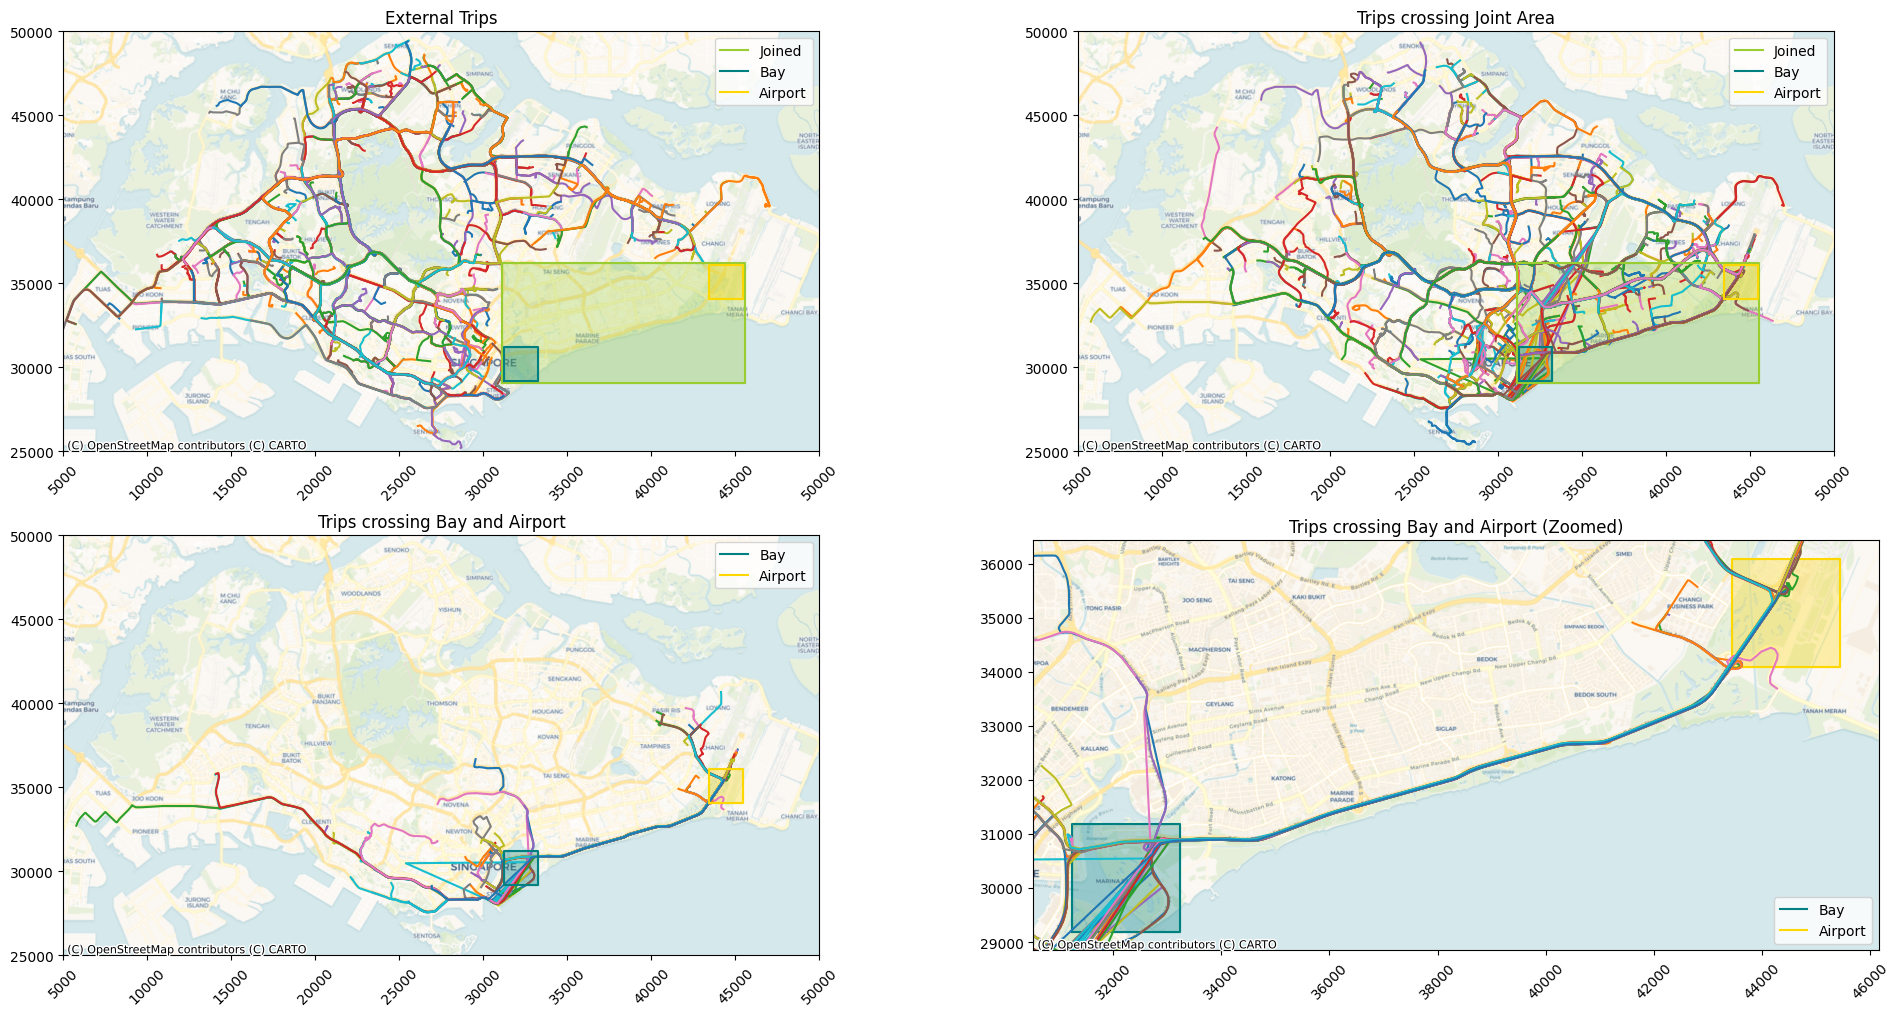

In [20]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing Bay and Airport')
ax[1][1].set_title('Trips crossing Bay and Airport (Zoomed)')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for a in [ax[0][0], ax[0][1], ax[1][0]]:
    _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
    _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
    _ = a.set_ylim(25000, 50000)
    _ = a.set_xlim(5000, 50000)
    _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
    _ = a.legend()
_ = bay_bb.plot_xy(axes=ax[1][1], color='teal', label='Bay')
_ = airport_bb.plot_xy(axes=ax[1][1], color='gold', label='Airport')
_ = cx.add_basemap(ax[1][1], crs=3414, source=cx.providers.CartoDB.Voyager)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
_ = plt.legend()

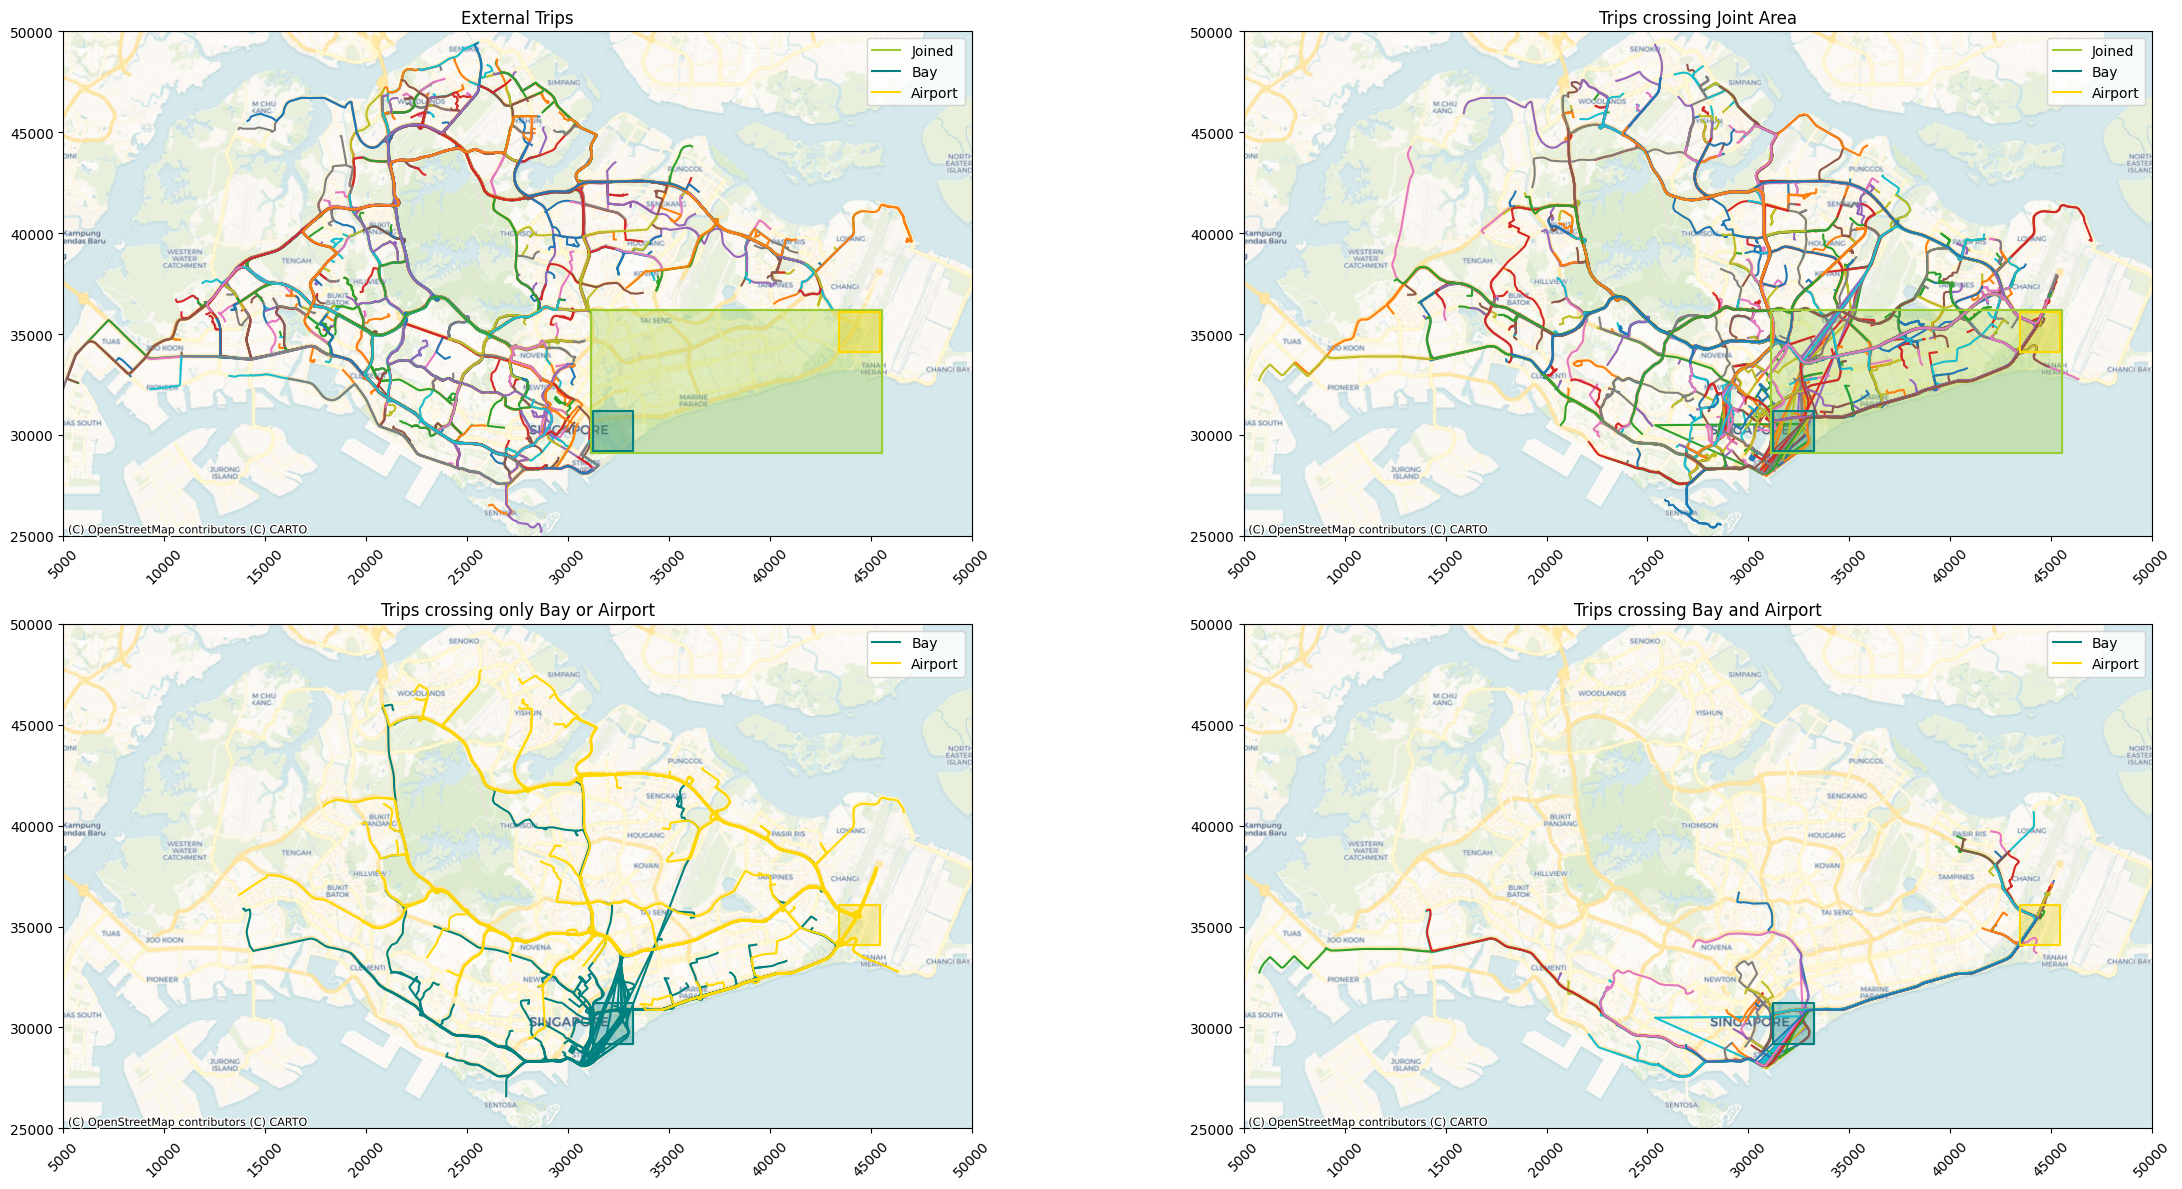

In [33]:
_, ax = plt.subplots(2, 2, figsize=(24, 12))
_ = TemporalPointSequencePlotter.plot_sequences_xy(external_trips['Trajectory'], axes=ax[0][0], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(possible_trips['Trajectory'], axes=ax[0][1], show_markers=False,
                                                   show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(bay_trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   color='teal', show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(airport_trips['Trajectory'], axes=ax[1][0], show_markers=False,
                                                   color='gold', show_grid=False)
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax[1][1], show_markers=False,
                                                   show_grid=False)
ax[0][0].set_title('External Trips')
ax[0][1].set_title('Trips crossing Joint Area')
ax[1][0].set_title('Trips crossing only Bay or Airport')
ax[1][1].set_title('Trips crossing Bay and Airport')
_ = joined_bb.plot_xy(axes=ax[0][0], color='yellowgreen', label='Joined')
_ = joined_bb.plot_xy(axes=ax[0][1], color='yellowgreen', label='Joined')
for r in ax:
    for a in r:
        _ = bay_bb.plot_xy(axes=a, color='teal', label='Bay')
        _ = airport_bb.plot_xy(axes=a, color='gold', label='Airport')
        _ = a.set_ylim(25000, 50000)
        _ = a.set_xlim(5000, 50000)
        _ = cx.add_basemap(a, crs=3414, source=cx.providers.CartoDB.Voyager)
        _ = a.legend()
_ = plt.legend()
_ = plt.tight_layout()

In [34]:
t = trips.copy()
t['Speed'] = t['Speed'].apply(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].apply(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].apply(lambda x: x.as_hexwkb())
t.to_csv(f'{data}/trips.csv')

nt = pd.concat([
    external_trips.copy(),
    non_trips_internal.copy(),
])
nt['Speed'] = nt['Speed'].apply(lambda x: x.as_hexwkb())
nt['Bearing'] = nt['Bearing'].apply(lambda x: x.as_hexwkb())
nt['Trajectory'] = nt['Trajectory'].apply(lambda x: x.as_hexwkb())
nt.to_csv(f'{data}/non_trips.csv')

## Splitting trajectories into one-leg trips

In [35]:
trips = pd.read_csv(f'{data}/trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
non_trips = pd.read_csv(f'{data}/non_trips.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trips.head()

Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing   
Trajectory ID                                                      
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  \
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...   
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...   
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...   
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...   

                                                      Trajectory  
Trajectory ID                                                     
307            [POINT(42785.54134319292 34504.381721159094)@2...  
558            [POINT(41607.49359226519 34913.5484173436)@201...  
587            [POINT(30597.0248582485 29070.689170268586)@20...  
2667           [POINT(28892.932740888984 28472.34898658451)@2...  
4887           [POINT(42285.252753209694 35054.245528254985)@...

In [36]:
geometry_trips = trips.copy()
geometry_trips['Is Inside'] = geometry_trips['Trajectory'].map(
    lambda trip: trip.is_spatially_contained_in(bay_bb).temporal_or(
        trip.is_spatially_contained_in(airport_bb)))
geometry_trips['Time Inside'] = geometry_trips['Is Inside'].map(lambda t: t.when_true())
geometry_trips['Period'] = geometry_trips['Time Inside'].map(lambda t: t.to_period())
geometry_trips['Time Outside'] = geometry_trips.apply(lambda row: row['Is Inside'].at(row['Period']).when_false(),
                                                      axis=1)
geometry_trips['Single Trips'] = geometry_trips.apply(lambda row: row['Trajectory'].at(row['Time Outside']), axis=1)
geometry_trips.head()

Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing   
Trajectory ID                                                      
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  \
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...   
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...   
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...   
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...   

                                                      Trajectory   
Trajectory ID                                                      
307            [POINT(42785.54134319292 34504.381721159094)@2...  \
558            [POINT(41607.49359226519 34913.5484173436)@201...   
587            [POINT(30597.0248582485 29070.689170268586)@20...   
2667           [POINT(28892.932740888984 28472.34898658451)@2...   
4887           [POINT(42285.252753209694 35054.245528254985)@...   

                                                       Is Inside   
Trajectory ID                                                      
307            {[f@2019-04-15 09:20:32+02, f@2019-04-15 09:21...  \
558            {[f@2019-04-13 09:26:04+02, f@2019-04-13 09:28...   
587            {[f@2019-04-18 15:29:21+02, f@2019-04-18 15:31...   
2667           {[f@2019-04-08 15:53:50+02, f@2019-04-08 15:59...   
4887           {[f@2019-04-18 11:17:55+02, f@2019-04-18 11:21...   

                                                     Time Inside   
Trajectory ID                                                      
307            {(2019-04-15 09:21:31.393074+02, 2019-04-15 09...  \
558            {(2019-04-13 09:28:46.834542+02, 2019-04-13 09...   
587            {(2019-04-18 15:31:24.894614+02, 2019-04-18 15...   
2667           {(2019-04-08 15:59:42.593122+02, 2019-04-08 16...   
4887           {(2019-04-18 11:21:31.71048+02, 2019-04-18 11:...   

                                                          Period   
Trajectory ID                                                      
307            (2019-04-15 09:21:31.393074+02, 2019-04-15 09:...  \
558            (2019-04-13 09:28:46.834542+02, 2019-04-13 09:...   
587            (2019-04-18 15:31:24.894614+02, 2019-04-18 15:...   
2667           (2019-04-08 15:59:42.593122+02, 2019-04-08 16:...   
4887           (2019-04-18 11:21:31.71048+02, 2019-04-18 11:3...   

                                                    Time Outside   
Trajectory ID                                                      
307            {[2019-04-15 09:21:56.079923+02, 2019-04-15 09...  \
558            {[2019-04-13 09:29:16.48236+02, 2019-04-13 09:...   
587            {[2019-04-18 15:32:58.602575+02, 2019-04-18 15...   
2667           {[2019-04-08 16:02:19.582652+02, 2019-04-08 16...   
4887           {[2019-04-18 11:21:54.955721+02, 2019-04-18 11...   

                                                    Single Trips  
Trajectory ID                                                     
307            {[POINT(43452.1091071125 34102.63668181222)@20...  
558            {[POINT(43452.10910577187 34107.51561859604)@2...  
587            {[POINT(33232.57398532677 30888.75409305662)@2...  
2667           {[POINT(33232.573990247314 30881.22062351536)@...  
4887           {[POINT(43452.10910188905 34102.30547075576)@2...

In [37]:
geometry_one_leg_trips = geometry_trips[['Single Trips', 'Speed', 'Bearing']].copy()
geometry_one_leg_trips['Single Trips'] = geometry_one_leg_trips['Single Trips'].apply(
    lambda trip: trip.sequences())
geometry_one_leg_trips = geometry_one_leg_trips.explode('Single Trips').rename({'Single Trips': 'Trip'},
                                                                               axis=1)
geometry_one_leg_trips.insert(0, 'Trip #', geometry_one_leg_trips.groupby('Trajectory ID').cumcount() + 1)
geometry_one_leg_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
307                 1  [POINT(43452.1091071125 34102.63668181222)@201...  \
558                 1  [POINT(43452.10910577187 34107.51561859604)@20...   
587                 1  [POINT(33232.57398532677 30888.75409305662)@20...   
2667                1  [POINT(33232.573990247314 30881.22062351536)@2...   
4887                1  [POINT(43452.10910188905 34102.30547075576)@20...   

                                                           Speed   
Trajectory ID                                                      
307            [17.44@2019-04-15 09:20:32+02, 19.09@2019-04-1...  \
558            [12.947844@2019-04-13 09:26:04+02, 13.4163065@...   
587            [13.172646522521973@2019-04-18 15:29:21+02, 13...   
2667           [5.2587247@2019-04-08 15:53:50+02, 6.253172@20...   
4887           [3.48@2019-04-18 11:17:55+02, 3.56@2019-04-18 ...   

                                                         Bearing  
Trajectory ID                                                     
307            [121@2019-04-15 09:20:32+02, 125@2019-04-15 09...  
558            [123@2019-04-13 09:26:04+02, 121@2019-04-13 09...  
587            [125@2019-04-18 15:29:21+02, 125@2019-04-18 15...  
2667           [143@2019-04-08 15:53:50+02, 149@2019-04-08 15...  
4887           [285@2019-04-18 11:17:55+02, 289@2019-04-18 11...

In [38]:
geometry_one_leg_trips['Speed'] = geometry_one_leg_trips.apply(
    lambda row: row['Speed'].at(row['Trip'].period()), axis=1)
geometry_one_leg_trips['Bearing'] = geometry_one_leg_trips.apply(
    lambda row: row['Bearing'].at(row['Trip'].period()), axis=1)
geometry_one_leg_trips.head()

Trip #                                               Trip   
Trajectory ID                                                              
307                 1  [POINT(43452.1091071125 34102.63668181222)@201...  \
558                 1  [POINT(43452.10910577187 34107.51561859604)@20...   
587                 1  [POINT(33232.57398532677 30888.75409305662)@20...   
2667                1  [POINT(33232.573990247314 30881.22062351536)@2...   
4887                1  [POINT(43452.10910188905 34102.30547075576)@20...   

                                                           Speed   
Trajectory ID                                                      
307            [12.560212268181818@2019-04-15 09:21:56.079923...  \
558            [14.242468538639999@2019-04-13 09:29:16.48236+...   
587            [21.036578833560945@2019-04-18 15:32:58.602575...   
2667           [20.619674702083998@2019-04-08 16:02:19.582652...   
4887           [14.745135582000001@2019-04-18 11:21:54.955721...   

                                                         Bearing  
Trajectory ID                                                     
307            [224.1382238181818@2019-04-15 09:21:56.079923+...  
558            [213@2019-04-13 09:29:16.48236+02, 213@2019-04...  
587            [88.038455@2019-04-18 15:32:58.602575+02, 86@2...  
2667           [88@2019-04-08 16:02:19.582652+02, 88@2019-04-...  
4887           [214.7734326@2019-04-18 11:21:54.955721+02, 21...

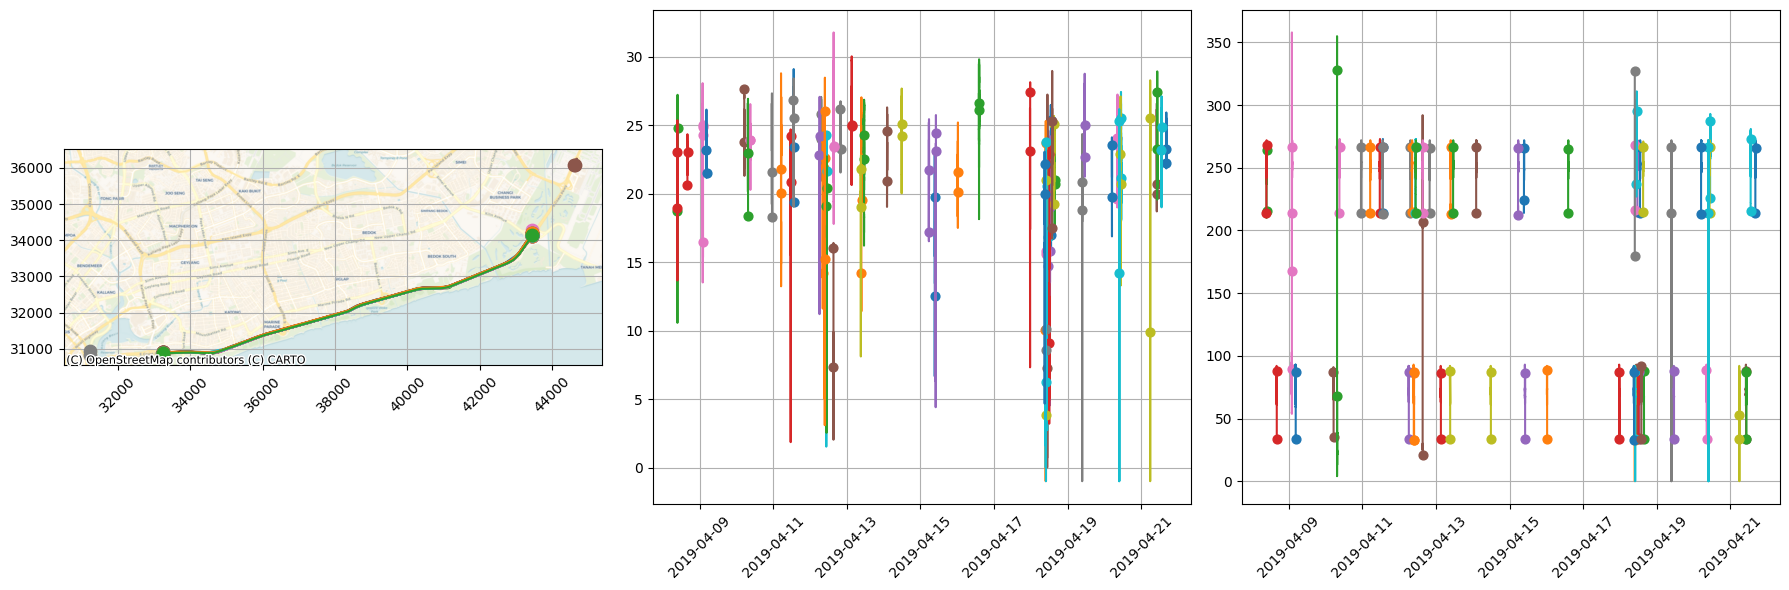

In [39]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))

_ = TemporalPointSequencePlotter.plot_sequences_xy(geometry_one_leg_trips['Trip'], axes=ax[0])
_ = cx.add_basemap(ax[0], crs=3414, source=cx.providers.CartoDB.Voyager)

_ = TemporalSequencePlotter.plot_sequences(geometry_one_leg_trips['Speed'], axes=ax[1])
_ = TemporalSequencePlotter.plot_sequences(geometry_one_leg_trips['Bearing'], axes=ax[2])
plt.tight_layout()

## Trajectory Heatmap

In [40]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [41]:
bbox: STBox = TemporalPointExtentAggregator.aggregate(trips['Trajectory'])

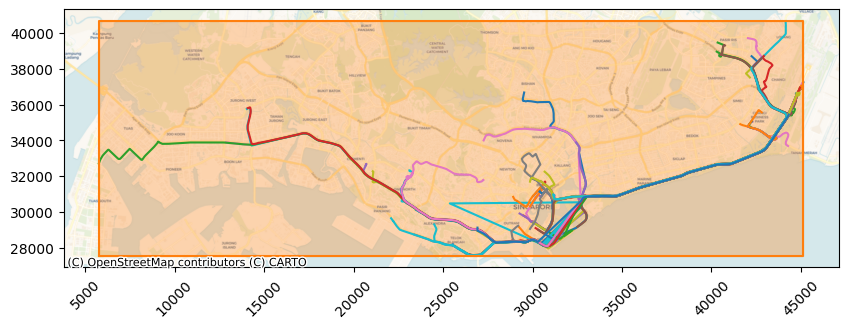

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trips['Trajectory'], axes=ax, show_markers=False,
                                                   show_grid=False)
_ = bbox.plot_xy(axes=ax)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In [44]:
heat_df = pd.DataFrame(data={'Tile': bbox.tile(size=500)})
heat_df['# Trajectories'] = heat_df['Tile'].progress_map(
    lambda tile: sum(trips['Trajectory'].map(lambda tp: tp.ever_intersects(tile))))
heat_df['X'] = heat_df['Tile'].map(lambda tile: (tile.xmin() + tile.xmax()) / 2)
heat_df['Y'] = heat_df['Tile'].map(lambda tile: (tile.ymin() + tile.ymax()) / 2)
heat_df.head()

  0%|          | 0/2160 [00:00<?, ?it/s]

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5500,27500),(6000,28000))               0  5750.0  \
1  SRID=3414;STBOX X((6000,27500),(6500,28000))               0  6250.0   
2  SRID=3414;STBOX X((6500,27500),(7000,28000))               0  6750.0   
3  SRID=3414;STBOX X((7000,27500),(7500,28000))               0  7250.0   
4  SRID=3414;STBOX X((7500,27500),(8000,28000))               0  7750.0   

         Y  
0  27750.0  
1  27750.0  
2  27750.0  
3  27750.0  
4  27750.0

In [45]:
svy21 = pyproj.CRS('EPSG:3414')
wgs84 = pyproj.CRS('EPSG:4326')

project = partial(transform, pyproj.Transformer.from_crs(svy21, wgs84, always_xy=True).transform)

heat_df['Coords'] = pd.Series(shp.points(heat_df['X'], heat_df['Y'])).map(project)
heat_df['Lat'] = heat_df['Coords'].map(lambda p: p.y)
heat_df['Lon'] = heat_df['Coords'].map(lambda p: p.x)
heat_df.head()

Tile  # Trajectories       X   
0  SRID=3414;STBOX X((5500,27500),(6000,28000))               0  5750.0  \
1  SRID=3414;STBOX X((6000,27500),(6500,28000))               0  6250.0   
2  SRID=3414;STBOX X((6500,27500),(7000,28000))               0  6750.0   
3  SRID=3414;STBOX X((7000,27500),(7500,28000))               0  7250.0   
4  SRID=3414;STBOX X((7500,27500),(8000,28000))               0  7750.0   

         Y                                         Coords       Lat   
0  27750.0   POINT (103.6333952671853 1.2672278759264077)  1.267228  \
1  27750.0   POINT (103.63788790813453 1.267228220971269)  1.267228   
2  27750.0  POINT (103.64238055029409 1.2672285581749374)  1.267229   
3  27750.0  POINT (103.64687319363618 1.2672288875374023)  1.267229   
4  27750.0  POINT (103.65136583813299 1.2672292090586534)  1.267229   

          Lon  
0  103.633395  
1  103.637888  
2  103.642381  
3  103.646873  
4  103.651366

In [46]:
heat_df.to_csv(f'{data}/heatmap.csv', index=False)

In [47]:
heat_df = pd.read_csv(f'{data}/heatmap.csv')

In [54]:
fig = px.density_mapbox(heat_df, lat='Lat', lon='Lon', z='# Trajectories',
                        radius=20,
                        zoom=11,
                        mapbox_style='open-street-map',
                        width=1500,
                        height=800,
                        )
fig.show()

In [55]:
fig.write_image('heatmap.png')

## Metric extraction

In [56]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [57]:
trajectories['Distance'] = trajectories['Trajectory'].map(lambda t: t.length())
trajectories['Avg Speed'] = trajectories['Speed'].map(lambda s: s.time_weighted_average())
trajectories['Avg Direction'] = trajectories['Bearing'].map(lambda b: b.time_weighted_average())
trajectories['Travel Time'] = trajectories['Trajectory'].map(lambda t: t.duration())
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory   
Trajectory ID                                                      
10             [POINT(24215.820244986906 31560.706204192793)@...  \
23             [POINT(39193.172144329044 35077.03281919307)@2...   
24             [POINT(39245.69537137267 34777.94277160995)@20...   
66             [POINT(21696.95171721036 47355.26736557279)@20...   
83             [POINT(22378.434417648372 46630.44463095692)@2...   

                   Distance  Avg Speed  Avg Direction     Travel Time  
Trajectory ID                                                          
10              9981.788426   8.826872      66.015734 0 days 00:19:04  
23             26175.446781  20.932771     270.597551 0 days 00:21:06  
24             17238.537375  17.090260     280.790227 0 days 00:16:53  
66             11050.764649   9.190391     136.770070 0 days 00:23:40  
83             30706.466229  15.394563      99.915604 0 days 00:33:58

## Close cars identification

In [58]:
trajectories = pd.read_csv(f'{data}/singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': partial(TGeomPointSeq.from_hexwkb, srid=3414)
})
trajectories.head()

Speed   
Trajectory ID                                                      
10             [3.3176403@2019-04-09 11:25:50+02, 4.543249@20...  \
23             [15.630654335021973@2019-04-21 02:42:49+02, 16...   
24             [1.2949033@2019-04-12 13:11:46+02, 2.835166@20...   
66             [0.438045620918274@2019-04-15 04:24:31+02, 3.0...   
83             [5.88@2019-04-21 14:21:17+02, 13.39@2019-04-21...   

                                                         Bearing   
Trajectory ID                                                      
10             [131@2019-04-09 11:25:50+02, 133@2019-04-09 11...  \
23             [349@2019-04-21 02:42:49+02, 349@2019-04-21 02...   
24             [342@2019-04-12 13:11:46+02, 345@2019-04-12 13...   
66             [13@2019-04-15 04:24:31+02, 12@2019-04-15 04:2...   
83             [64@2019-04-21 14:21:17+02, 34@2019-04-21 14:2...   

                                                      Trajectory  
Trajectory ID                                                     
10             [POINT(24215.820244986906 31560.706204192793)@...  
23             [POINT(39193.172144329044 35077.03281919307)@2...  
24             [POINT(39245.69537137267 34777.94277160995)@20...  
66             [POINT(21696.95171721036 47355.26736557279)@20...  
83             [POINT(22378.434417648372 46630.44463095692)@2...

In [60]:
cc_data = []
for i, trip in trajectories['Trajectory'].items():
    for j, other in trajectories['Trajectory'].items():
        if j <= i:
            continue
        if trip.is_ever_within_distance(other, 10):
            print(f'{i} within {j}')
            cc_data.append((i, trip, j, other))

14836 within 38532
19166 within 55507
20431 within 81088
24960 within 62922
25897 within 71255
28866 within 48191
58860 within 75134
65640 within 66797
65895 within 69835
73899 within 83488


In [61]:
close_cars = pd.DataFrame(cc_data, columns=['ID 1', 'Trajectory 1', 'ID 2', 'Trajectory 2'])
close_cars.head()

ID 1                                       Trajectory 1   ID 2   
0  14836  [POINT(18218.211306723046 38102.225979641924)@...  38532  \
1  19166  [POINT(21481.87197524448 33634.75479134711)@20...  55507   
2  20431  [POINT(13387.937864608457 37121.1783856671)@20...  81088   
3  24960  [POINT(31548.415428967895 34103.23967082107)@2...  62922   
4  25897  [POINT(26228.36037967567 31372.277784147558)@2...  71255   

                                        Trajectory 2  
0  [POINT(36857.22242170114 32046.71707625586)@20...  
1  [POINT(44706.81773674855 36329.72243829873)@20...  
2  [POINT(26055.032483416482 32097.4279062861)@20...  
3  [POINT(20540.815202953247 37777.07131678395)@2...  
4  [POINT(44562.94314598582 36000.43349028984)@20...

In [62]:
close_cars.to_csv(f'{data}/close_cars.csv', index=False)